In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [12]:
inspector.get_table_names()

['measurement', 'station']

In [13]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Calculate the date 1 year ago from the last data point in the database
session.query(func.max(Measurement.date)).all()

date = dt.datetime(2017, 8, 23)
year_ago = date - dt.timedelta(days=365)

2016-08-23 00:00:00


In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       Measurement.prcp]
results = session.query(*sel).\
    filter(Measurement.date > year_ago).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date = [] 
prcp = []

for result in results:
    date.append(result[0]) 
    prcp.append(result[1])

In [20]:
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)
df.head()

,precipitation
date,
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,NaN
2016-08-28,2.07


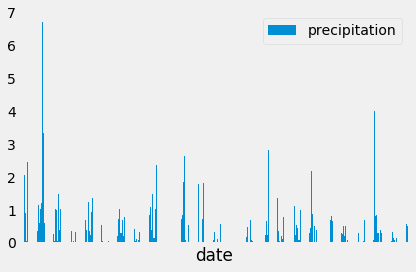

In [25]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)
df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar()
plt.tick_params(axis='x', which='both', labelbottom=False)
plt.grid(which='both', axis='both')
plt.tight_layout()
plt.show()

In [68]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,344.000000
mean,0.431308
std,0.705240
min,0.000000
25%,0.010000
50%,0.140000
75%,0.565000
max,6.700000


In [26]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.station)]
results = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(results)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station = 'USC00519281'

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

results = session.query(*sel).\
    filter(Measurement.station==station).all()
print(results)

[(54.0, 85.0, 71.66378066378067)]


In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station = 'USC00519281'

sel = [Measurement.date, 
       Measurement.tobs]
results = session.query(*sel).\
    filter(Measurement.station==station, Measurement.date > year_ago).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

Text(0.5, 1.0, '')

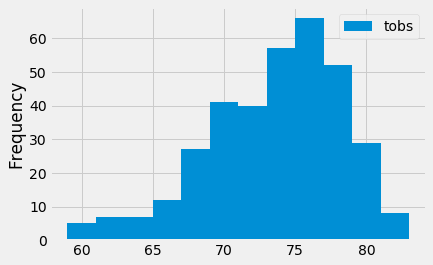

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df = pd.DataFrame(results, columns=['date', 'tobs'])
df.set_index('date', inplace=True)

df.hist(bins=12, label="tobs")
plt.legend(loc="best")
plt.ylabel("Frequency")
plt.title(None)

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_chart = calc_temps('2017-04-30', '2017-05-15')
print(trip_chart)

[(58.0, 74.32222222222222, 80.0)]


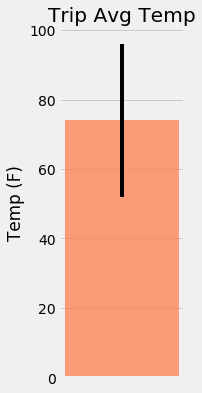

<Figure size 432x288 with 0 Axes>

In [44]:
# Plot the results from your previous query as a bar chart. 
df = pd.DataFrame(trip_chart, columns=['tmin', 'avg', 'tmax'])
x = 0
# Use the average temperature for the y value
y = int(df.avg)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = int(df.tmax)-int(df.tmin)

plt.bar(x, y, yerr=error, color='coral', alpha=0.75, align='edge')
fig = plt.gcf()
fig.set_size_inches(2,6)

# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tick_params(axis='x', which='both', labelbottom=False)
plt.grid(which="major", axis='x')
plt.show()
plt.tight_layout()

In [81]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date='2017-04-30'
end_date='2017-05-15'
sel = [Station.station,
       Station.name,
       Station.latitude,
       Station.longitude, 
       Station.elevation]
results = session.query(*sel).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(Measurement.prcp.desc()).all()
print(results) 

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


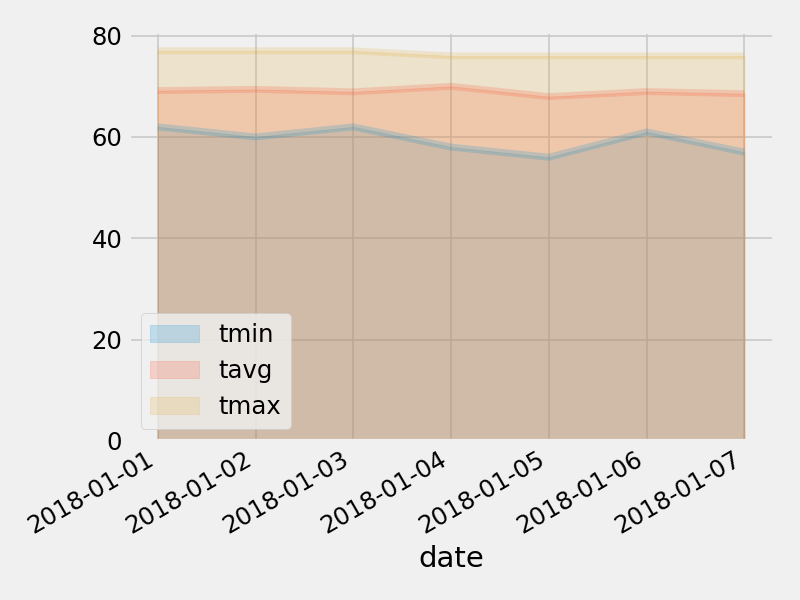

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
